In [129]:
import sys
 
sys.path.append('../')

In [393]:
import json
from tqdm import tqdm
from collections import defaultdict

import openai
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

from src.constants import API_KEYS
from src.hierarchy_tree import HierarchyTree
from src.utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
openai.api_key = API_KEYS["cybor"][0]

In [12]:

# Example dummy function hard coded to return the same weather
# In production, this could be your backend API or an external API
def get_current_weather(location, unit="fahrenheit"):
    """Get the current weather in a given location"""
    weather_info = {
        "location": location,
        "temperature": "72",
        "unit": unit,
        "forecast": ["sunny", "windy"],
    }
    return json.dumps(weather_info)


def run_conversation(messages, functions):
    # Step 1: send the conversation and available functions to GPT
    messages = messages
    functions = functions
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo-0613",
        messages=messages,
        functions=functions,
        function_call="auto",  # auto is default, but we'll be explicit
    )
    response_message = response["choices"][0]["message"]

    # Step 2: check if GPT wanted to call a function
    if response_message.get("function_call"):
        # Step 3: call the function
        # Note: the JSON response may not always be valid; be sure to handle errors
        available_functions = {
            "get_current_weather": get_current_weather,
        }  # only one function in this example, but you can have multiple
        function_name = response_message["function_call"]["name"]
        fuction_to_call = available_functions[function_name]
        function_args = json.loads(response_message["function_call"]["arguments"])
        function_response = fuction_to_call(
            location=function_args.get("location"),
            unit=function_args.get("unit"),
        )

        # Step 4: send the info on the function call and function response to GPT
        messages.append(response_message)  # extend conversation with assistant's reply
        messages.append(
            {
                "role": "function",
                "name": function_name,
                "content": function_response,
            }
        )  # extend conversation with function response
        second_response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo-0613",
            messages=messages,
        )  # get a new response from GPT where it can see the function response
        return response, second_response

TypeError: run_conversation() missing 2 required positional arguments: 'messages' and 'functions'

In [19]:
content = """Assume you are Joshua, an experienced data analyst. I will give you a detailed description of objects in an image and will ask you to complete a few tasks:

Description: "There is a 256 by 256 aerial image. One building is located at x = 67 and y = 8, in the top left of the image, with a size = 5775 pixels. One building is located at x = 114 and y = 59, in the center towards the top of the image, with a size = 3185 pixels. One building is located at x = 188 and y = 83, in the top right of the image, with a size = 2565 pixels. One building is located at x = 196 and y = 239, in the bottom right of the image, with a size = 2337 pixels. One building is located at x = 188 and y = 162, in the bottom right of the image, with a size = 6160 pixels. One building is located at x = 145 and y = 207, in the center towards the bottom of the image, with a size = 8374 pixels. One building is located at x = 153 and y = 41, in the center towards the top of the image, with a size = 3120 pixels. One building is located at x = 199 and y = 2, in the top right of the image, with a size = 7884 pixels. One building is located at x = 222 and y = 60, in the top right of the image, with a size = 2300 pixels. One small car is located at x = 30 and y = 34, in the top left of the image, with a size = 182 pixels. One small car is located at x = 38 and y = 50, in the top left of the image, with a size = 168 pixels. One small car is located at x = 56 and y = 70, in the top left of the image, with a size = 240 pixels. One small car is located at x = 86 and y = 83, in the top left of the image, with a size = 288 pixels."

Task 1: Determine spatial relations between objects. Task 2: Extract high-level spatial patterns between the objects, such as direction, clustering, dispersion, encirclement, interposition, etc. Task 3: Generate one or more independent image captions with high-level significant spatial patterns. Each starts with "CAP", with no longer than 32 tokens.
"""

In [29]:
content.replace("\n", " ")

'Assume you are Joshua, an experienced data analyst. I will give you a detailed description of objects in an image and will ask you to complete a few tasks:  Description: "There is a 256 by 256 aerial image. One building is located at x = 67 and y = 8, in the top left of the image, with a size = 5775 pixels. One building is located at x = 114 and y = 59, in the center towards the top of the image, with a size = 3185 pixels. One building is located at x = 188 and y = 83, in the top right of the image, with a size = 2565 pixels. One building is located at x = 196 and y = 239, in the bottom right of the image, with a size = 2337 pixels. One building is located at x = 188 and y = 162, in the bottom right of the image, with a size = 6160 pixels. One building is located at x = 145 and y = 207, in the center towards the bottom of the image, with a size = 8374 pixels. One building is located at x = 153 and y = 41, in the center towards the top of the image, with a size = 3120 pixels. One build

In [24]:
messages = [{
    "role": "user", 
    "content": "Question 1: Given two short sides of a right triangle are 5 and 10, calculate its hypotenuse. Question 2: Given two short sides of a right triangle are 6 and 7, calculate its hypotenuse"
}]

functions = [
        {
            "name": "get_hypotenuse",
            "description": "Get the hypotenuse of a right triangle given its other two sides",
            "parameters": {
                "type": "object",
                "properties": {
                    "a": {
                        "type": "string",
                        "description": "List of numbers. Each element represent the length of one short leg of a right triangle",
                    },
                    "b": {
                        "type": "string",
                        "description": "List of numbers. Each element represent the length of another short leg of a right triangle",
                    }
                },
                "required": ["a", "b"],
            },
        }
    ]


response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo-0613",
    messages=messages,
    functions=functions,
    function_call="auto",  # auto is default, but we'll be explicit
)
response_message = response["choices"][0]["message"]

In [25]:
response_message

<OpenAIObject at 0x1e183c85810> JSON: {
  "content": null,
  "function_call": {
    "arguments": "{\n  \"a\": \"5,6\",\n  \"b\": \"10,7\"\n}",
    "name": "get_hypotenuse"
  },
  "role": "assistant"
}

# DBSCAN

In [178]:
from sklearn.cluster import DBSCAN, OPTICS

In [179]:
train_labels_path = 'H:/xview/train_labels/xView_train.geojson'
annotations_path = "H:/xview/annotations"
train_images_path = "F:/train_images"
train_blocks_path = "F:/train_blocks"
type_csvs_path = "H:/xview/data.csv"
hierarchy_path = "H:/xview/src/hierarchy.json"

In [180]:
with open("../results/unique_blocks_info.json", "r") as f:
    unique_blocks_info = json.load(f)

In [210]:
tree = HierarchyTree(hierarchy_path)

In [392]:
distance_freq = defaultdict(lambda: [])

for block_id in tqdm(unique_blocks_info):

    polygons = get_polygons(unique_blocks_info[block_id], image_size=256)
    X_coordinates = [poly['rectangle_coordinates'] for poly in polygons["polygons"]]
    types = [tree.find_significant_parent(poly['object']) for poly in polygons["polygons"]]
    
    types_indices = np.unique(types, return_inverse=True)[1]
    X = np.concatenate([X_coordinates, np.expand_dims(types_indices, axis=1)], axis=1)

    dist_matrix = csr_matrix(get_distance_matrix(X))

    weights_matrix = minimum_spanning_tree(dist_matrix).toarray()
    edges = np.stack(np.triu_indices(n=weights_matrix.shape[0], k=1)).T
    weights = weights_matrix[np.triu_indices(n=weights_matrix.shape[0], k=1)]
    edges_types = np.array(types)[edges]

    valid_edges_condition = edges_types[:, 0] == edges_types[:, 1] 
    valid_weights_condition = weights > 0

    valid_indices = np.where(valid_weights_condition & valid_edges_condition)[0]
    valid_edges = edges[valid_indices]
    valid_weights = weights[valid_indices]
    valid_edges_types = edges_types[valid_indices] 
    
    for i, (start, _) in enumerate(valid_edges_types):
        distance_freq[start].append(valid_weights[i])

100%|███████████████████████████████████████████████████████████████████████████| 12831/12831 [01:31<00:00, 140.88it/s]


In [397]:
distance_thres_elbow = {key: elbow_cut_off(item) for key, item in distance_freq.items()}
distance_thres_percentile = {key: np.percentile(item, 75) for key, item in distance_freq.items()}

In [175]:
valid_edges_types

array([['building', 'building'],
       ['building', 'building'],
       ['building', 'building'],
       ['building', 'building'],
       ['building', 'building'],
       ['vehicle', 'vehicle'],
       ['vehicle', 'vehicle']], dtype='<U8')

In [176]:
valid_weights

array([1.801e+01, 1.000e-02, 1.000e-02, 1.000e-02, 1.000e-02, 1.301e+01,
       1.401e+01])

In [196]:
distance_freq.keys()

dict_keys(['building', 'infrastructure', 'vehicle', 'facility', 'maritime vessel', 'aircraft'])

3.838662166304645

0.6981347220709843

In [239]:
per_75 = np.percentile(np.log(np.array(distance_freq["vehicle"]) + 1), 75)
per_25 = np.percentile(np.log(np.array(distance_freq["vehicle"]) + 1), 25)
median = np.median(np.log(np.array(distance_freq["vehicle"]) + 1))

thres = median + 1 * (per_75 - per_25)

In [240]:
np.exp(7)

1096.6331584284585

In [242]:
np.exp(median) - 1

13.162946437965903

In [251]:
len(distance_freq["infrastructure"])

3330

In [248]:
np.percentile(np.array(distance_freq["infrastructure"]), 75)

22.01

In [390]:
array = np.array(distance_freq["vehicle"])

def elbow_cut_off(array, bin_size=2.0, window_size=6, increase_thres=4)
    array_min = array.min()
    array_max = array.max()
    bins = np.arange(np.floor(array_min / bin_size), np.ceil(array_max / bin_size) + 1) * bin_size
    counts, bins = np.histogram(array, bins)
    starts = bins[1:]

    perc_counts = (counts - counts.min()) / (counts.max() - counts.min())
    perc_starts = (starts - starts.min()) / (starts.max() - starts.min())
    weights = perc_counts + perc_starts

    indices = np.tile(np.expand_dims(np.arange(len(counts) - window_size + 1), axis=1), (1, window_size)) + np.arange(window_size)
    increase_trends = (weights[indices][:, :-1] < weights[indices][:, 1:]).sum(axis=1)
    thres_index = np.where(increase_trends >= increase_thres)[0][0]

    return starts[thres_index]

In [391]:
threshold

24.0

3

In [311]:
perc_counts + perc_starts

array([1.        , 0.12586933, 0.08100695, 0.12557547, 0.11323342,
       0.10089137, 0.08854932, 0.12498776, 0.1126457 , 0.13282398,
       0.13674209, 0.17318053, 0.16083848, 0.19727691, 0.18493486,
       0.21324322, 0.23342149, 0.2373396 , 0.22499755, 0.25330591,
       0.24096386, 0.27740229, 0.27319032, 0.28523852, 0.32167695,
       0.32559506, 0.33764326, 0.34156137, 0.36173964, 0.35752767,
       0.36957586, 0.38975414, 0.39367225, 0.40572044, 0.40963855,
       0.44607699, 0.4499951 , 0.45391321, 0.46596141, 0.4780096 ,
       0.49005779, 0.4939759 , 0.5060241 , 0.53433245, 0.55451073,
       0.54216867, 0.55421687, 0.56626506, 0.57831325, 0.59036145,
       0.60240964, 0.61445783, 0.62650602, 0.63855422, 0.65060241,
       0.67078068, 0.6746988 , 0.68674699, 0.70692526, 0.71084337,
       0.72289157, 0.73493976, 0.75511803, 0.75903614, 0.77108434,
       0.78313253, 0.8033108 , 0.815359  , 0.82740719, 0.8313253 ,
       0.84337349, 0.85542169, 0.86746988, 0.87951807, 0.89156

In [301]:
(np.arange(np.floor(array_min / 2), np.ceil(array_max / 2) + 1) * 2.0).shape

(154,)

In [280]:
array_max

305.6650343115585

(array([1.4917e+04, 4.0110e+03, 2.4230e+03, 1.8220e+03, 1.2360e+03,
        9.5400e+02, 7.2500e+02, 5.9700e+02, 4.5000e+02, 3.7200e+02,
        3.0600e+02, 1.9900e+02, 1.6000e+02, 1.1100e+02, 7.1000e+01,
        3.8000e+01, 1.9000e+01, 1.2000e+01, 4.0000e+00, 2.0000e+00]),
 array([1.00000000e-02, 1.52927517e+01, 3.05755034e+01, 4.58582551e+01,
        6.11410069e+01, 7.64237586e+01, 9.17065103e+01, 1.06989262e+02,
        1.22272014e+02, 1.37554765e+02, 1.52837517e+02, 1.68120269e+02,
        1.83403021e+02, 1.98685772e+02, 2.13968524e+02, 2.29251276e+02,
        2.44534027e+02, 2.59816779e+02, 2.75099531e+02, 2.90382283e+02,
        3.05665034e+02]),
 <a list of 20 Patch objects>)

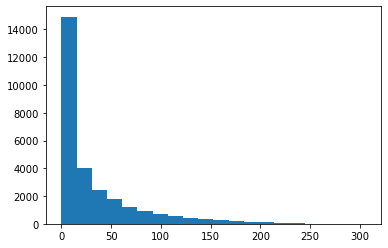

In [257]:
plt.hist(np.array(distance_freq["vehicle"]), bins=20)


In [116]:
edges

array([[0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [1, 2],
       [1, 3],
       [1, 4],
       [2, 3],
       [2, 4],
       [3, 4]])

In [117]:
weights

array([0.00000000e+00, 6.01000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.81937662e+01, 0.00000000e+00, 1.00000000e-02,
       0.00000000e+00, 2.50100000e+01])

In [112]:
for i, (start_type, end_type) in enumerate(np.array(types)[valid_edges]):
    print(valid_weights[i])
    print(i, start_type, end_type)

6.01
0 building building
38.19376618407357
1 building building
0.01
2 building building
25.01
3 building building


1675.tif_14


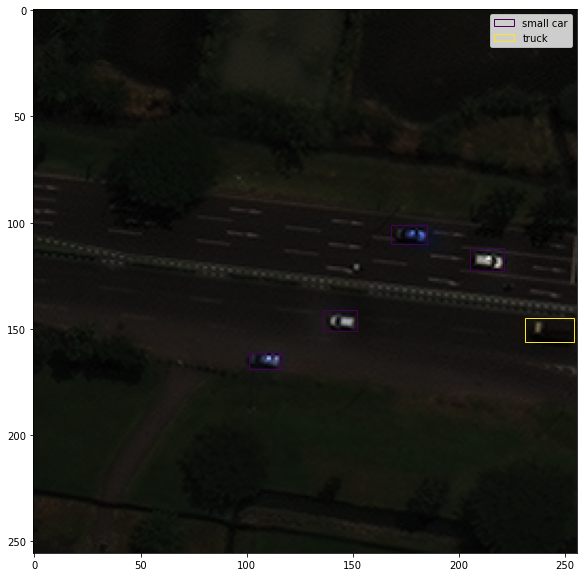

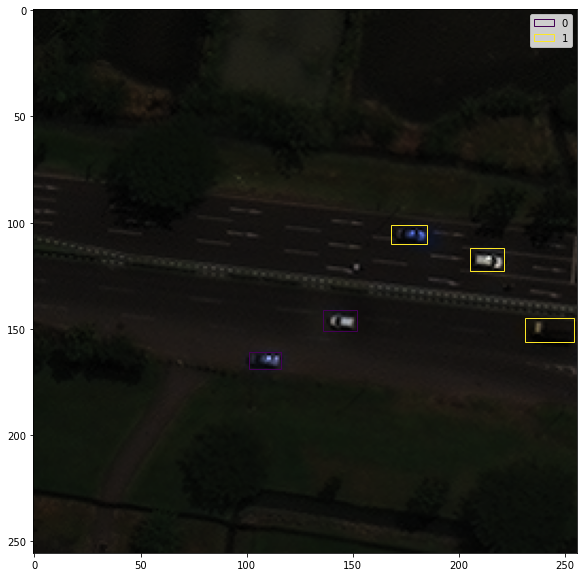

'1675.tif_14'

In [22]:
block_id = random.sample(unique_blocks_info.keys(), 1)[0]

polygons = get_polygons(unique_blocks_info[block_id], image_size=256)
X_coordinates = [poly['rectangle_coordinates'] for poly in polygons["polygons"]]
types = [poly['object'] for poly in polygons["polygons"]]
types_indices = np.unique(types, return_inverse=True)[1]
X = np.concatenate([X_coordinates, np.expand_dims(types_indices, axis=1)], axis=1)



clustering = DBSCAN(eps = 150, min_samples=1, metric=box_distance_with_type).fit(X)

print(block_id)
random_test_sub_blocks(polygons, block_id, types, train_blocks_path)
random_test_sub_blocks(polygons, block_id, clustering.labels_, train_blocks_path)

In [7]:
X

array([[-15,  22,  44,  74,   0],
       [162,  29, 212,  77,   0],
       [ 44, -34, 177,  54,   0],
       [228,  44, 249,  65,   1],
       [151,  89, 163,  99,   2],
       [140,  99, 151, 109,   2],
       [218,  25, 232,  40,   2],
       [135, 124, 148, 138,   2],
       [207,  11, 226,  28,   2],
       [140, 117, 168, 153,   3]], dtype=int64)

In [10]:
box_distance(X[0], X[1])

118.0

In [58]:
clustering.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64)